# **Import Modules**

In [1]:
import sys

import os

import random as pyrand

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sys.path.insert(0, '../input/deeplearning-utils')
sys.path.insert(0, '../input/swintransformertf')

In [2]:
from utils.ops import plot

from utils.tf.ops import io, eval as tf_eval

In [3]:
from swintransformer import SwinTransformer

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

from tqdm import tqdm

In [5]:
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

In [6]:
import tensorflow as tf

from tensorflow.keras import backend, optimizers, regularizers

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_addons as tfa

# **Config**

In [7]:
def set_seed(tf_seed=0, np_seed=0, py_rand=0, py_hash=0):

    os.environ['PYTHONHASHSEED'] = str(py_hash)
    pyrand.seed(py_rand)

    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)

In [8]:
PATH = {'224': 'cisc22placesandscene224x224'}

In [9]:
class Config:
    
    SEED = 2053
    
    IMAGE_SIZE = (224, 224)

    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 32
        
    SPLIT =10
        
    EPOCHS = 50
    
    TRAINING = True

In [10]:
set_seed(Config.SEED)

In [11]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
    
except ValueError:
  
    tpu = None

if tpu is not None:
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    
    strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

GCS_DS_PATH = KaggleDatasets().get_gcs_path(PATH['224'])

In [13]:
augmentations = []

augmentations.append(preprocessing.RandomFlip(mode='horizontal'))
augmentations.append(preprocessing.RandomContrast(factor=0.8))
augmentations.append(preprocessing.RandomRotation(factor=0.1, dtype=tf.float32))

augmentations = Sequential(augmentations)

# **Load Data**

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [15]:
train_rec = tf.io.gfile.glob(GCS_DS_PATH + '/train/train/*')

train_rec = np.array(train_rec)

print(len(train_rec))

50


In [16]:
def train_processing(x, y):
        
    x = tf.cast(x, dtype=tf.float32)
    x /= 255.0
        
    y = tf.one_hot(y, depth=6)
    
    return augmentations(x, training=Config.TRAINING), y

In [17]:
def split_generator(train_idx, val_idx):
    
    dtype = {'image': 'bytes', 'label': 'int64'}
    
    reader = io.TfRecordReader(features_dtype=dtype,  image_key='image', 
                               tfrecord_shape=[*Config.IMAGE_SIZE, 3],  
                               shape=None, channels=3,  func=None)
    
    train_data = tf.data.TFRecordDataset(train_rec[train_idx], num_parallel_reads=AUTOTUNE)
    train_data = train_data.with_options(ignore_order)

    train_data = train_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    train_data = train_data.shuffle(512, reshuffle_each_iteration=True)
    train_data = train_data.batch(Config.TRAIN_BATCH_SIZE)
    train_data = train_data.prefetch(AUTOTUNE)
    train_data = train_data.map(train_processing)
    
    val_data = tf.data.TFRecordDataset(train_rec[val_idx], num_parallel_reads=AUTOTUNE)
    val_data = val_data.with_options(ignore_order)

    val_data = val_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    val_data = val_data.batch(Config.VAL_BATCH_SIZE)
    val_data = val_data.prefetch(AUTOTUNE)
    val_data = val_data.map(train_processing)
    
    return train_data, val_data

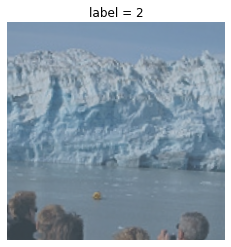

In [18]:
sample_x, sample_y = split_generator(0, 1)[0].unbatch().as_numpy_iterator().next()

plt.imshow(sample_x)
plt.title(f'label = {int(sample_y.argmax())}')
plt.axis('off')
plt.show()

# **Build Model**

In [19]:
input_shape = (*Config.IMAGE_SIZE, 3)

In [20]:
with strategy.scope():
    
    backbone = SwinTransformer('swin_tiny_224', include_top=False, pretrained=True, use_tpu=True)

102039552/102036641 [==============================] - 2s 0us/step


In [21]:
def build_model():
    
    backbone.trainable = False
    
    # ===================================================================================
    
    inputs =  Input(shape=input_shape)

    features = backbone(inputs)
    
    # ===================================================================================

    y_logits = Dense(6, name='y_logits')(features)
    y_proba = Activation('softmax', name='y_proba')(y_logits)
    
    # ===================================================================================

    model = Model(inputs, y_proba)
    
    # ===================================================================================
    
    optimizer = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
    
    loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.25, name='categorical_crossentropy')
    metrics = tf.metrics.CategoricalAccuracy(name='accuracy_score')
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # ===================================================================================

    return model

In [22]:
build_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
swin_tiny_224 (SwinTransform (None, 768)               27769058  
_________________________________________________________________
y_logits (Dense)             (None, 6)                 4614      
_________________________________________________________________
y_proba (Activation)         (None, 6)                 0         
Total params: 27,773,672
Trainable params: 4,614
Non-trainable params: 27,769,058
_________________________________________________________________


# **Train Model**

In [23]:
weights_path = tf.io.gfile.glob('../input/csscciswimv0/weights-*.h5')

print(len(weights_path))

def scheduler(step):
    
    def _scheduler(epoch, lr):
        
        if epoch > 0 and epoch % step == 0:
            
            return max(1e-6, lr * tf.math.exp(-0.75))
        
        else:
            
            return max(1e-6, lr)
    
    return _scheduler

kfold = KFold(n_splits=Config.SPLIT, shuffle=False)

for i, (train_idx, val_idx) in enumerate(kfold.split(train_rec)):
    
    train_data, val_data = split_generator(train_idx, val_idx)
    
    print(f'fold {i} - {"=" * 100}')
    
    with strategy.scope():
        
        model = build_model()
    
    if i < len(weights_path):
        
        model.load_weights(weights_path[i])
        
    callbacks = []
    
    callbacks.append(LearningRateScheduler(schedule=scheduler(step=10), verbose=1))
    
    model.fit(train_data, epochs=Config.EPOCHS, validation_data=val_data, callbacks=callbacks)
    
    model.save_weights(f'weights-{i}.h5')
    
    backend.clear_session()

    # stop cv
    if i == 0:
        
        break

1
fold 0 - ====================================================================================================
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 185s 433ms/step - loss: 1.0185 - accuracy_score: 0.9194 - val_loss: 1.0148 - val_accuracy_score: 0.9223
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 161s 417ms/step - loss: 1.0196 - accuracy_score: 0.9177 - val_loss: 1.0130 - val_accuracy_score: 0.9121
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 161s 418ms/step - loss: 1.0175 - accuracy_score: 0.9201 - val_loss: 1.0103 - val_accuracy_score: 0.9201
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
384/384 [==============================] - 161s 418ms/step - lo